# Home-made xG model

Objetivo: elaborar un modelo de Machine Learning que pueda predecir con el mayor nivel de precisión posible la probabilidad de un tiro de terminar en gol, es decir, su xG (expected goals)

In [2]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")

C:\Users\Usuario\miniconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Usuario\miniconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Carga de datos

In [3]:
comps = sb.competitions()
#comps[comps['competition_name']=='Premier League']

In [4]:
# Me quedo con los partidos jugados en el Mundial de Qatar 2022
wc22 = sb.matches(2,27)
#wc22

In [5]:
# Hago una lista con todos los match id
#ids = list(wc22['match_id'])

In [6]:
#dfs = []

# Iterás y vas guardando cada DataFrame
#for i in ids:
#    events = sb.events(i)
#    dfs.append(events)

# Al final los concatenás todos
#wc_events = pd.concat(dfs, ignore_index=True)

In [7]:
#wc_events.to_csv('datosmodelo.csv')

In [8]:
#list(wc_events.columns.sort_values())

In [9]:
#shots=wc_events[(wc_events['type']=='Shot')]
#shots[['x', 'y']] = shots['location'].apply(pd.Series)

In [10]:
#shots.to_csv('shots.csv',index=False)

In [11]:
#shortcut
shots = pd.read_csv('shots.csv')

## Primary Exploratory Data Analysis (EDA)
In this section, an EDA will be performed under a general perspective, seeking for "macro" findings within the data

In [12]:
# Dataset size
print("Shape:", shots.shape)

Shape: (9908, 116)


In [13]:
# Statistical summary
shots.describe()

,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,...,block_deflection,dribble_no_touch,block_save_block,player_off_permanent,goalkeeper_success_in_play,goalkeeper_lost_out,half_start_late_video_start,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Calculate the amount of missing values per columns
null_counts = shots.isnull().sum()
null_counts = null_counts[null_counts > 0]

# Calculate missing value percentage
null_percentage = (null_counts / len(shots)) * 100

# Summary table
null_table = pd.DataFrame({
    'Column': null_counts.index,
    'Missing Values': null_counts.values,
    'Percentage': null_percentage.round(2)
})

# Sort descending
null_table = null_table.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)
null_table

,Column,Missing Values,Percentage
0,ball_receipt_outcome,9908,100.00
1,pass_switch,9908,100.00
2,50_50,9908,100.00
3,tactics,9908,100.00
4,substitution_replacement,9908,100.00
...,...,...,...
85,shot_aerial_won,8999,90.83
86,under_pressure,7772,78.44
87,shot_first_time,6965,70.30
88,shot_key_pass_id,2733,27.58


In [15]:
shots.value_counts('under_pressure')

under_pressure
True    2136
Name: count, dtype: int64

In [16]:
shots.value_counts('shot_first_time')

shot_first_time
True    2943
Name: count, dtype: int64

In [17]:
shots.value_counts('shot_aerial_won')

shot_aerial_won
True    909
Name: count, dtype: int64

In [18]:
# Categorical variables
categorical_cols = shots.select_dtypes(include='object').columns
print(categorical_cols)

Index(['id', 'location', 'off_camera', 'out', 'play_pattern', 'player',
       'position', 'possession_team', 'related_events', 'shot_aerial_won',
       'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_freeze_frame', 'shot_key_pass_id', 'shot_one_on_one',
       'shot_outcome', 'shot_technique', 'shot_type', 'team', 'timestamp',
       'type', 'under_pressure', 'shot_open_goal', 'shot_saved_off_target',
       'shot_saved_to_post', 'shot_redirect', 'shot_deflected',
       'shot_follows_dribble'],
      dtype='object')



Distribution of the target variable
shot_outcome
Off T               3197
Blocked             2880
Saved               2209
Goal                 988
Wayward              396
Post                 170
Saved Off Target      45
Saved to Post         23
Name: count, dtype: int64


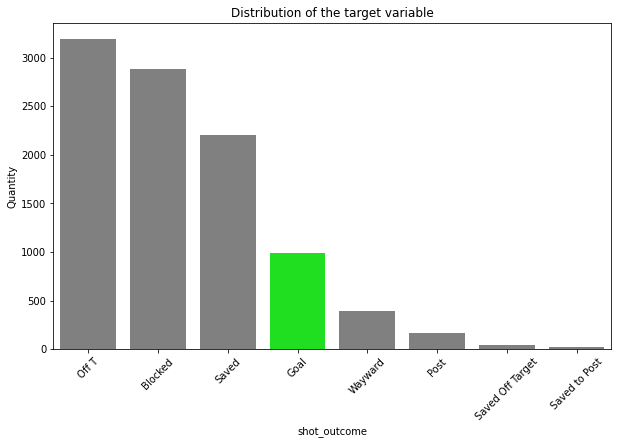

In [19]:
# Distribution of the target variable
if 'shot_outcome' in shots.columns:
    print("\nDistribution of the target variable")
    print(shots['shot_outcome'].value_counts())

    # Calcular el orden de las categorías de mayor a menor
    order = shots['shot_outcome'].value_counts().index

    # Definir el tamaño del gráfico más grande
    plt.figure(figsize=(10,6))  # ancho=10, alto=6 (podés ajustar)
    colors = ['lime' if outcome == 'Goal' else 'grey' for outcome in order]
    # Graficar ordenado
    sns.countplot(x='shot_outcome', data=shots, order=order,palette=colors)

    plt.title("Distribution of the target variable")
    plt.xlabel("shot_outcome")
    plt.ylabel("Quantity")
    plt.xticks(rotation=45)  # rotar etiquetas si son largas
    plt.show()


### Observaciones principales 
- El dataset tiene demasiadas columnas, por lo que se requiere una técnica de reducción de dimensionalidad.  
- Los valores faltantes representan la forma en que Statsbomb indica _False_, por lo que la estructura de este tipo de columnas debe transformarse a un formato binario (0-1).  
- 29 de las 118 columnas son categóricas, representando menos del 25% del total de columnas.  
- La variable objetivo (_shot_outcome_) debe transformarse en una variable dummy, indicando 1 si el resultado del disparo es gol y 0 en caso contrario.  
- Muchas de las 118 columnas son inútiles, por lo tanto, se eliminará una cantidad significativa de ellas.  

## Análisis de reducción de dimensionalidad  
Dado que el dataset tiene 118 columnas, este problema genera dificultades para analizar adecuadamente los datos, por lo que se aplicarán algunas técnicas de reducción de dimensionalidad. El objetivo es obtener un dataset reducido y más manejable, conservando la mayor cantidad posible de información valiosa. Por lo tanto, en la siguiente sección, cuando dividamos el dataset en conjuntos de entrenamiento y prueba, mantendremos únicamente las columnas que surjan de este análisis.  

In [20]:
# Eliminar columnas con más del 95% de nulos
null_percentage = shots.isnull().mean()
cols_to_drop_nulls = null_percentage[null_percentage ==1 ].index
print(f"Columnas eliminadas por muchos nulos (100%):\n{list(cols_to_drop_nulls)}\n")
#shots_reduced.drop(columns=cols_to_drop_nulls, inplace=True)

Columnas eliminadas por muchos nulos (100%):
['ball_receipt_outcome', 'ball_recovery_recovery_failure', 'carry_end_location', 'clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_right_foot', 'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type', 'foul_committed_advantage', 'foul_committed_card', 'foul_committed_offensive', 'foul_committed_penalty', 'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive', 'foul_won_penalty', 'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_punched_out', 'goalkeeper_technique', 'goalkeeper_type', 'interception_outcome', 'miscontrol_aerial_won', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_end_location', 'pass_height', 'pass_inswinging', 'pass_length', 'pass_outcome', 'pass_outswinging', 'pass_recipient', 'pass_

In [21]:
# Manually delete irrelevant columns (IDs, names, time data, etc)
cols_to_drop_manual = ['duration', 'id', 'index', 'match_id','off_camera', 
                       'player_id','player','team', 'team_id', 'timestamp','possession_team', 'possession_team_id',
                      'related_events','shot_key_pass_id','shot_statsbomb_xg','out','period','possession','second',
                      'type','shot_saved_off_target', 'shot_saved_to_post','shot_end_location','shot_freeze_frame',
                      'position']  # ajusta según tu dataset
existing_cols_to_drop = [col for col in cols_to_drop_manual if col in shots.columns]
print(f"Manually deleted columns:\n{existing_cols_to_drop}\n")
#shots_reduced.drop(columns=existing_cols_to_drop, inplace=True)

Manually deleted columns:
['duration', 'id', 'index', 'match_id', 'off_camera', 'player_id', 'player', 'team', 'team_id', 'timestamp', 'possession_team', 'possession_team_id', 'related_events', 'shot_key_pass_id', 'shot_statsbomb_xg', 'out', 'period', 'possession', 'second', 'type', 'shot_saved_off_target', 'shot_saved_to_post', 'shot_end_location', 'shot_freeze_frame', 'position']



In [22]:
# Unir las listas de columnas a quitar
cols_to_drop = set(cols_to_drop_manual) | set(cols_to_drop_nulls)

# Generar lista con las columnas que quedan
remaining_cols = [col for col in shots.columns if col not in cols_to_drop]

print(f"Columns remaining: {len(remaining_cols)}")
print(remaining_cols)

Columns remaining: 15
['location', 'minute', 'play_pattern', 'shot_aerial_won', 'shot_body_part', 'shot_first_time', 'shot_one_on_one', 'shot_outcome', 'shot_technique', 'shot_type', 'under_pressure', 'shot_open_goal', 'shot_redirect', 'shot_deflected', 'shot_follows_dribble']


## Train-test split

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(shots, shots["shot_outcome"]):
    strat_train_set = shots.loc[train_index]
    strat_test_set = shots.loc[test_index]

In [24]:
strat_train_set.shape

(7926, 116)

In [25]:
strat_test_set.shape

(1982, 116)

## Main Exploratory Data Analysis (EDA)
In this section, the reduced dataset will be analyzed in detail in search of valuable patterns and insights, as well as to get an overall picture of the data

In [26]:
shots_train=strat_train_set.copy()
shots_train = shots_train[remaining_cols]
shots_train.head()

,location,minute,play_pattern,shot_aerial_won,shot_body_part,shot_first_time,shot_one_on_one,shot_outcome,shot_technique,shot_type,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble
6373,"[115.4, 42.8]",29,Regular Play,NaN,Right Foot,True,NaN,Off T,Volley,Open Play,True,NaN,NaN,NaN,NaN
139,"[108.9, 45.0]",91,Regular Play,NaN,Right Foot,True,NaN,Saved to Post,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
6940,"[98.8, 59.3]",77,Regular Play,NaN,Right Foot,NaN,NaN,Saved,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
6348,"[92.7, 53.8]",39,From Throw In,NaN,Right Foot,NaN,NaN,Off T,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
2447,"[95.7, 40.3]",54,From Throw In,NaN,Right Foot,NaN,NaN,Blocked,Normal,Open Play,True,NaN,NaN,NaN,NaN


In [27]:
shots_train.dtypes

location                object
minute                   int64
play_pattern            object
shot_aerial_won         object
shot_body_part          object
shot_first_time         object
shot_one_on_one         object
shot_outcome            object
shot_technique          object
shot_type               object
under_pressure          object
shot_open_goal          object
shot_redirect           object
shot_deflected          object
shot_follows_dribble    object
dtype: object

In [28]:
shots_train.isna().sum()

location                   0
minute                     0
play_pattern               0
shot_aerial_won         7202
shot_body_part             0
shot_first_time         5570
shot_one_on_one         7563
shot_outcome               0
shot_technique             0
shot_type                  0
under_pressure          6251
shot_open_goal          7847
shot_redirect           7896
shot_deflected          7818
shot_follows_dribble    7920
dtype: int64

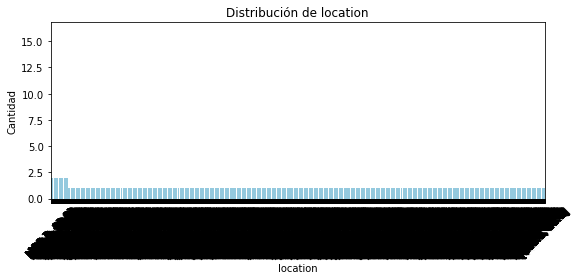

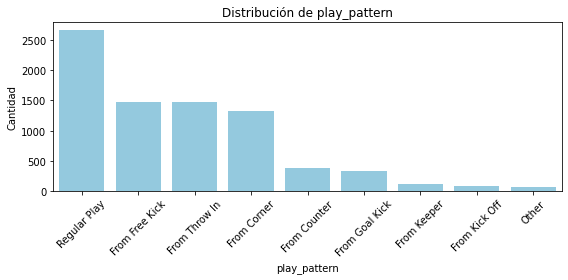

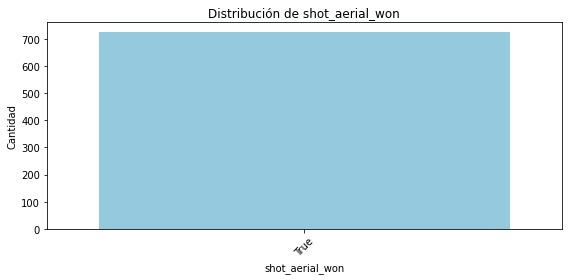

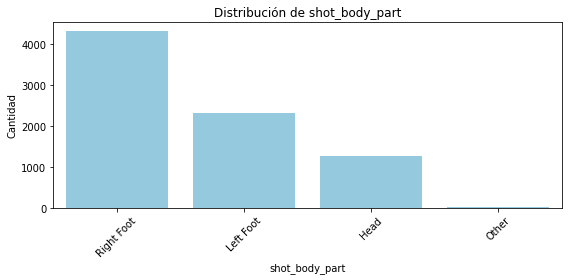

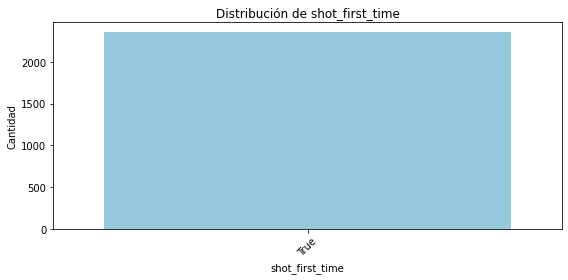

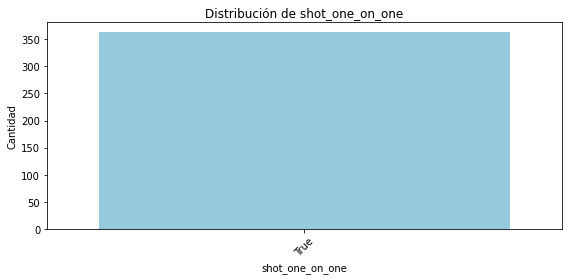

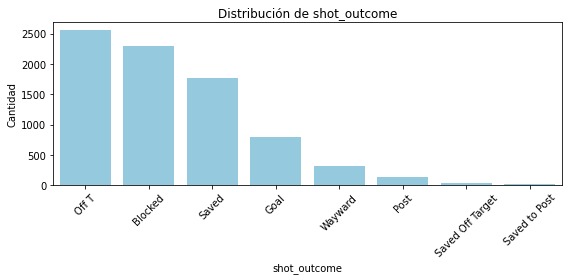

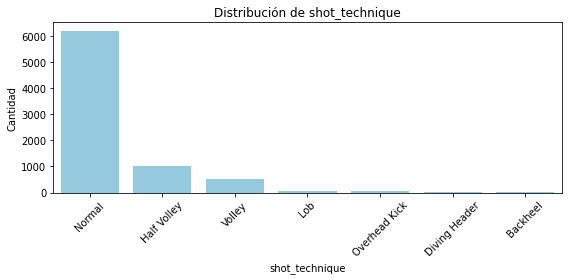

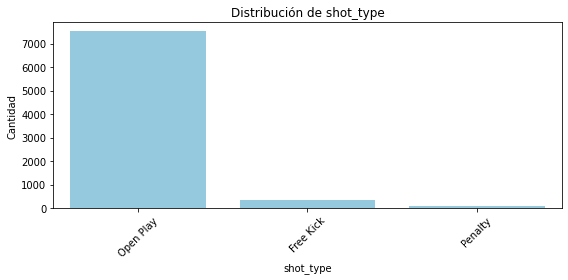

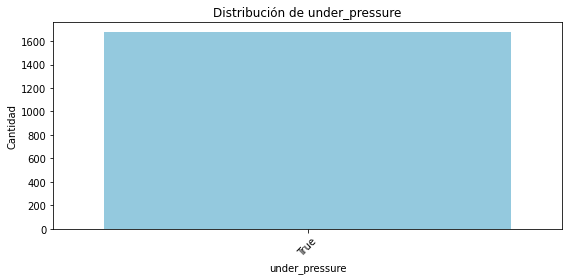

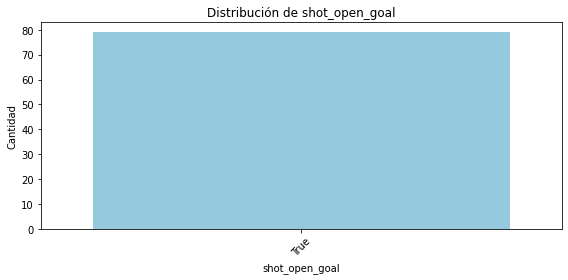

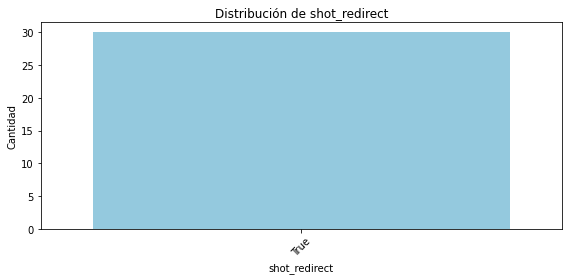

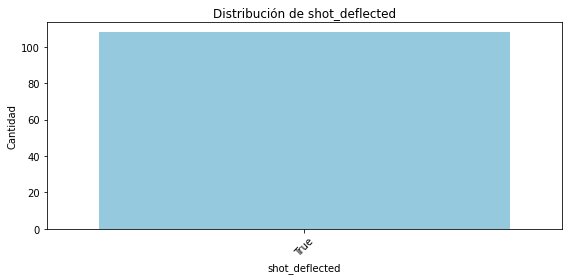

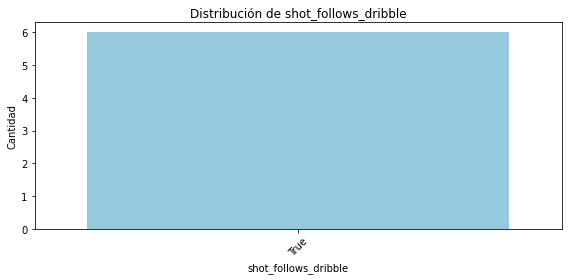

In [29]:
# Graficar cada columna
cat_cols = shots_train.select_dtypes(include='object').columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    order = shots_train[col].value_counts().index
    sns.countplot(x=col, data=shots_train, order=order, color='skyblue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45)  # rotar etiquetas si son largas
    plt.tight_layout()
    plt.show()

In [30]:
# Pruebo sustituir los NaN por 0 y los True por 1
shots_train = shots_train.replace(np.nan, 0)
shots_train = shots_train.replace(True, 1)

In [31]:
shots_train.isna().sum()

location                0
minute                  0
play_pattern            0
shot_aerial_won         0
shot_body_part          0
shot_first_time         0
shot_one_on_one         0
shot_outcome            0
shot_technique          0
shot_type               0
under_pressure          0
shot_open_goal          0
shot_redirect           0
shot_deflected          0
shot_follows_dribble    0
dtype: int64

In [32]:
shots_train.dtypes

location                object
minute                   int64
play_pattern            object
shot_aerial_won          int64
shot_body_part          object
shot_first_time          int64
shot_one_on_one          int64
shot_outcome            object
shot_technique          object
shot_type               object
under_pressure           int64
shot_open_goal           int64
shot_redirect            int64
shot_deflected           int64
shot_follows_dribble     int64
dtype: object

In [33]:
print(len(shots[shots['shot_outcome']=='Goal']),"goals out of",len(shots),'shots, accounting for a 9.97% goal rate')

988 goals out of 9908 shots, accounting for a 9.97% goal rate


## Observaciones principales  
- Como se mencionó en la sección de _Análisis Exploratorio Primario de los Datos_, las variables dummy deben ser reformateadas al formato binario.  
- La mayoría de los disparos provienen de jugadas en movimiento, lo cual es consistente con la naturaleza del juego.  
- Casi el 10% de los disparos terminaron en gol, mientras que la mayoría finalizaron fuera de portería o fueron bloqueados.  

## Preprocesado 
Sección para probar las distintas transformaciones antes de integrarlas al pipeline

In [34]:
# deshacemos los cambios que hicimos en la seccion anterior (que solo tenian fines de exploracion), ahora hacemos los definitivos
shots_train=strat_train_set.copy()
shots_train.head()

,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,...,block_save_block,shot_deflected,player_off_permanent,goalkeeper_success_in_play,shot_follows_dribble,goalkeeper_lost_out,half_start_late_video_start,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post
6373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# me quedo solo con el set de columnas que defini arriba
shots_train = shots_train[remaining_cols]
shots_train.head()

,location,minute,play_pattern,shot_aerial_won,shot_body_part,shot_first_time,shot_one_on_one,shot_outcome,shot_technique,shot_type,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble
6373,"[115.4, 42.8]",29,Regular Play,NaN,Right Foot,True,NaN,Off T,Volley,Open Play,True,NaN,NaN,NaN,NaN
139,"[108.9, 45.0]",91,Regular Play,NaN,Right Foot,True,NaN,Saved to Post,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
6940,"[98.8, 59.3]",77,Regular Play,NaN,Right Foot,NaN,NaN,Saved,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
6348,"[92.7, 53.8]",39,From Throw In,NaN,Right Foot,NaN,NaN,Off T,Normal,Open Play,NaN,NaN,NaN,NaN,NaN
2447,"[95.7, 40.3]",54,From Throw In,NaN,Right Foot,NaN,NaN,Blocked,Normal,Open Play,True,NaN,NaN,NaN,NaN


In [36]:
# Reemplazo los NaN por 0 y los True por 1
shots_train = shots_train.replace(np.nan, 0)
shots_train = shots_train.replace(True, 1)

In [37]:
import ast
shots_train['location_list'] = shots_train['location'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [np.nan, np.nan])
shots_train['x'] = shots_train['location_list'].apply(lambda loc: loc[0] if isinstance(loc, list) and len(loc) > 0 else np.nan)
shots_train['y'] = shots_train['location_list'].apply(lambda loc: loc[1] if isinstance(loc, list) and len(loc) > 1 else np.nan)
shots_train.head()

,location,minute,play_pattern,shot_aerial_won,shot_body_part,shot_first_time,shot_one_on_one,shot_outcome,shot_technique,shot_type,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble,location_list,x,y
6373,"[115.4, 42.8]",29,Regular Play,0,Right Foot,1,0,Off T,Volley,Open Play,1,0,0,0,0,"[115.4, 42.8]",115.4,42.8
139,"[108.9, 45.0]",91,Regular Play,0,Right Foot,1,0,Saved to Post,Normal,Open Play,0,0,0,0,0,"[108.9, 45.0]",108.9,45.0
6940,"[98.8, 59.3]",77,Regular Play,0,Right Foot,0,0,Saved,Normal,Open Play,0,0,0,0,0,"[98.8, 59.3]",98.8,59.3
6348,"[92.7, 53.8]",39,From Throw In,0,Right Foot,0,0,Off T,Normal,Open Play,0,0,0,0,0,"[92.7, 53.8]",92.7,53.8
2447,"[95.7, 40.3]",54,From Throw In,0,Right Foot,0,0,Blocked,Normal,Open Play,1,0,0,0,0,"[95.7, 40.3]",95.7,40.3


In [38]:
# Sustituyo los NaN por 0 y los True por 1, de modo de tener variables binarias sobre las caracteristicas del tiro
shots_train = shots_train[shots_train['x']<=120]

In [39]:
# Creo la variable binaria goal, que me dice 1 si el tiro termino en gol y 0 si no lo hizo
def clasificar_tiro(x):
    if x['shot_outcome']=='Goal':
        return 1
    else:
        return 0
shots_train['goal']=shots_train.apply(clasificar_tiro,axis=1)

In [40]:
# Aproximadaente un 10% de los tiros en esta muestra terminaron en gol
shots_train['goal'].value_counts()

goal
0    7136
1     790
Name: count, dtype: int64

In [41]:
# elimino 'location', 'location_list','shot_outcome'
shots_train = shots_train.drop(['location', 'location_list','shot_outcome'], axis=1)

In [42]:
# Tengo que convertir todas las variables cualitativas en dummies
cualitativas = shots_train.select_dtypes(include='object').columns
cualitativas

Index(['play_pattern', 'shot_body_part', 'shot_technique', 'shot_type'], dtype='object')

In [43]:
cualitativas = list(['play_pattern', 'shot_body_part', 'shot_technique', 'shot_type'])

In [44]:
# Funcion para convertir las variables cualitativas a dummies
def convertir_a_dummies(df, columna):
    # Convertir la columna cualitativa en dummies
    dummies = pd.get_dummies(df[columna], prefix=columna)
    
    # Concatenar las columnas dummies al DataFrame original
    df = pd.concat([df, dummies], axis=1)
    
    # Eliminar la columna original cualitativa
    df.drop(columns=[columna], inplace=True)
    
    return df

In [45]:
for i in range(len(cualitativas)):
    shots_train = convertir_a_dummies(shots_train,cualitativas[i])

In [46]:
# Reseteo el indice
shots_train = shots_train.reset_index(drop=True)

In [47]:
shots_train.head()

,minute,shot_aerial_won,shot_first_time,shot_one_on_one,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble,x,...,shot_technique_Backheel,shot_technique_Diving Header,shot_technique_Half Volley,shot_technique_Lob,shot_technique_Normal,shot_technique_Overhead Kick,shot_technique_Volley,shot_type_Free Kick,shot_type_Open Play,shot_type_Penalty
0,29,0,1,0,1,0,0,0,0,115.4,...,False,False,False,False,False,False,True,False,True,False
1,91,0,1,0,0,0,0,0,0,108.9,...,False,False,False,False,True,False,False,False,True,False
2,77,0,0,0,0,0,0,0,0,98.8,...,False,False,False,False,True,False,False,False,True,False
3,39,0,0,0,0,0,0,0,0,92.7,...,False,False,False,False,True,False,False,False,True,False
4,54,0,0,0,1,0,0,0,0,95.7,...,False,False,False,False,True,False,False,False,True,False


In [48]:
shots_train = shots_train.replace(True, 1)
shots_train = shots_train.replace(False, 0)

In [49]:
# El arco esta ubicado en las coordenadas (120,40), calculamos la distancia al arco y el angulo de tiro
import numpy as np
shots_train['distancia_arco'] = np.sqrt((shots_train['x'] - 120)**2 + (shots_train['y'] - 40)**2)

In [50]:
def calculate_shot_angle(x, y):
    left_post = np.array([120, 43.66])
    right_post = np.array([120, 36.34])
    shot_point = np.array([x, y])

    vec_left = left_post - shot_point
    vec_right = right_post - shot_point

    dot = np.dot(vec_left, vec_right)
    mag_left = np.linalg.norm(vec_left)
    mag_right = np.linalg.norm(vec_right)
    cos_angle = dot / (mag_left * mag_right)
    cos_angle = np.clip(cos_angle, -1, 1)
    angle = np.arccos(cos_angle)
    return np.degrees(angle)

shots_train['angulo'] = shots_train.apply(lambda row: calculate_shot_angle(row['x'], row['y']), axis=1)

In [51]:
calculate_shot_angle(119,40)

149.43678453061034

In [52]:
# Prueba, un tiro bien centrado (al rededor de 40) debe tener un ángulo cercano a 0 grados
shots_train[shots_train['x']==119.5][['x','y','angulo']].sort_values('x')

,x,y,angulo
2321,119.5,47.4,5.026249
6943,119.5,31.4,3.444084


In [53]:
# Defino una variable dummie que calcule si el tiro fue en franja central o no (franja comprendida entre los laterales de las areas)
def franja_central(x):
    if (x['y']>62)|(x['y']<18):
        return 0
    else:
        return 1
shots_train['franja_central'] = shots_train.apply(franja_central,axis=1)

In [54]:
# Creo la variable binaria dentro_del_area, que me dice 1 si el tiro fue dentro del area y 0 si fue de afuera
def dentro_area(x):
    if x['x']<102:
        return 0
    else:
        if x['y']>62:
            return 0
        elif x['y']<18:
            return 0
        else:
            return 1
shots_train['dentro_del_area'] = shots_train.apply(dentro_area,axis=1)

In [55]:
# Defino combinaciones
shots_train['distancia_arco*franja_central'] = shots_train['distancia_arco']*shots_train['franja_central']
shots_train['distancia/angulo'] = shots_train['distancia_arco'] / (shots_train['angulo'] + 1)
shots_train['first_time_dentro_area'] = shots_train['dentro_del_area'] * shots_train['shot_first_time']
shots_train['central_one_on_one'] = shots_train['franja_central'] * shots_train['shot_one_on_one']
shots_train['angulo_one_on_one'] = shots_train['angulo'] * shots_train['shot_one_on_one']

In [56]:
# Asi se ve el dataset
shots_train.head()

,minute,shot_aerial_won,shot_first_time,shot_one_on_one,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble,x,...,shot_type_Penalty,distancia_arco,angulo,franja_central,dentro_del_area,distancia_arco*franja_central,distancia/angulo,first_time_dentro_area,central_one_on_one,angulo_one_on_one
0,29,0,1,0,1,0,0,0,0,115.4,...,0,5.385165,65.135880,1,1,5.385165,0.081426,1,0,0.0
1,91,0,1,0,0,0,0,0,0,108.9,...,0,12.174153,31.077171,1,1,12.174153,0.379527,1,0,0.0
2,77,0,0,0,0,0,0,0,0,98.8,...,0,28.669322,10.864793,1,0,28.669322,2.416336,0,0,0.0
3,39,0,0,0,0,0,0,0,0,92.7,...,0,30.589704,12.224938,1,0,30.589704,2.313032,0,0,0.0
4,54,0,0,0,1,0,0,0,0,95.7,...,0,24.301852,17.128189,1,0,24.301852,1.340556,0,0,0.0


In [57]:
shots_train.columns

Index(['minute', 'shot_aerial_won', 'shot_first_time', 'shot_one_on_one',
       'under_pressure', 'shot_open_goal', 'shot_redirect', 'shot_deflected',
       'shot_follows_dribble', 'x', 'y', 'goal', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play',
       'shot_body_part_Head', 'shot_body_part_Left Foot',
       'shot_body_part_Other', 'shot_body_part_Right Foot',
       'shot_technique_Backheel', 'shot_technique_Diving Header',
       'shot_technique_Half Volley', 'shot_technique_Lob',
       'shot_technique_Normal', 'shot_technique_Overhead Kick',
       'shot_technique_Volley', 'shot_type_Free Kick', 'shot_type_Open Play',
       'shot_type_Penalty', 'distancia_arco', 'angulo', 'franja_central',
       'dentro_del_area', 'distancia_arco*franja_centr

In [58]:
corr_matrix = shots_train.corr()
corr_matrix["goal"].sort_values(ascending=False)

goal                             1.000000
angulo                           0.270328
shot_type_Penalty                0.241039
play_pattern_Other               0.223427
x                                0.201478
dentro_del_area                  0.180901
shot_open_goal                   0.174367
angulo_one_on_one                0.158528
central_one_on_one               0.124912
shot_one_on_one                  0.124548
shot_deflected                   0.113475
first_time_dentro_area           0.108870
shot_body_part_Other             0.056215
shot_first_time                  0.052685
shot_technique_Diving Header     0.040161
shot_technique_Lob               0.039882
shot_technique_Backheel          0.030813
play_pattern_From Counter        0.029583
shot_body_part_Head              0.020118
minute                           0.014791
shot_redirect                    0.013785
shot_technique_Volley            0.012378
shot_body_part_Right Foot        0.009063
shot_follows_dribble             0

Text(0.5, 1.0, 'Correlation Heatmap')

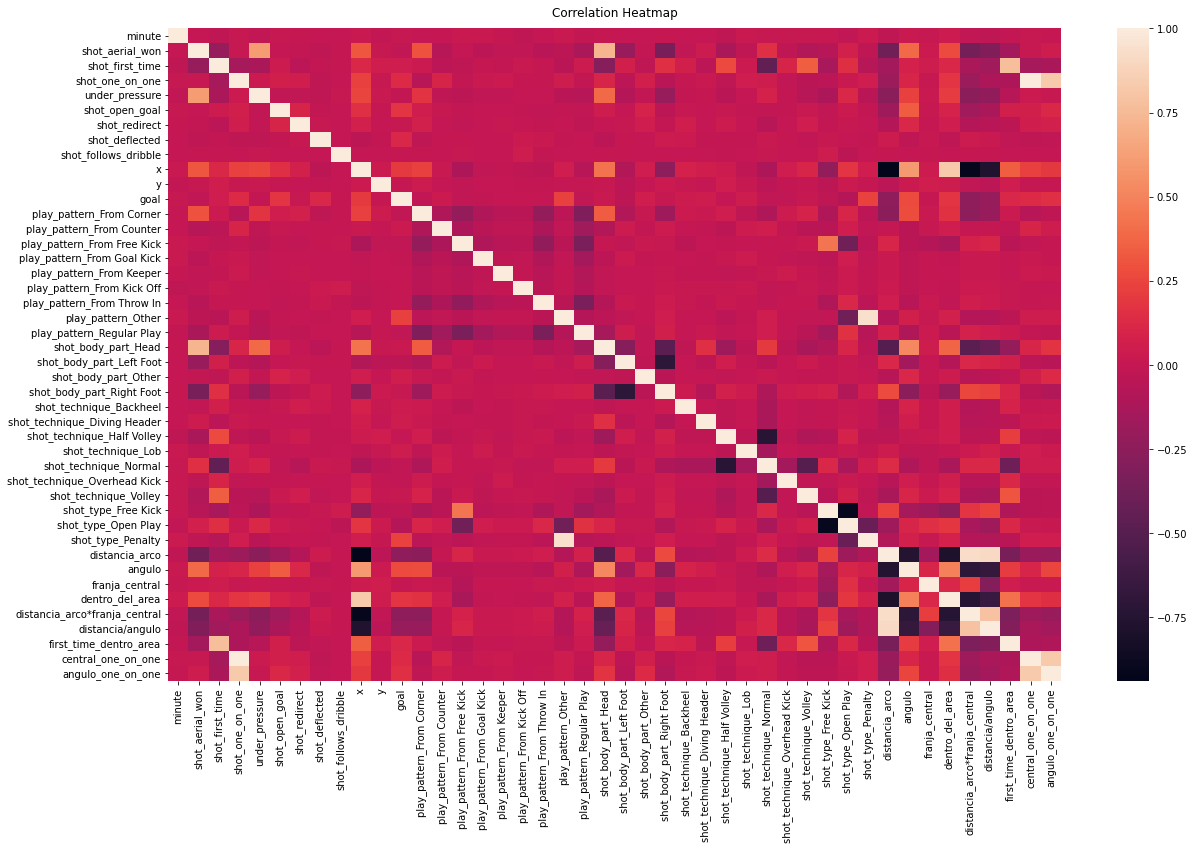

In [59]:
plt.figure(figsize=(20, 12))
heatmap = sns.heatmap(shots_train.corr(), cbar=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## Preparación de los datos para algoritmos de ML

In [61]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

sb_xg=strat_train_set["shot_statsbomb_xg"].copy()

strat_train_set = strat_train_set[['location', 'minute', 'play_pattern', 'shot_aerial_won', 'shot_body_part', 
             'shot_first_time', 'shot_one_on_one', 'shot_outcome', 'shot_technique', 'shot_type', 
             'under_pressure', 'shot_open_goal', 'shot_redirect', 'shot_deflected', 'shot_follows_dribble']]
strat_train_set['goal'] = strat_train_set['shot_outcome'].apply(lambda outcome: 1 if outcome=='Goal' else 0)
strat_train_set.drop(columns=['shot_outcome'], inplace=True)

shots_train=strat_train_set.drop("goal", axis=1)
shots_labels=strat_train_set["goal"].copy()

# ---------------------
# 1) Función de feature engineering
# ---------------------
def feature_engineering(df):
    df = df.copy()
    
    # Reemplazar nan por 0 y booleanos True/False por 1/0
    df = df.replace(np.nan, 0)
    df = df.replace(True, 1).replace(False, 0)

    # Parsear location
    df['location_list'] = df['location'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [np.nan, np.nan])
    df['x'] = df['location_list'].apply(lambda loc: loc[0] if isinstance(loc, list) and len(loc) > 0 else np.nan)
    df['y'] = df['location_list'].apply(lambda loc: loc[1] if isinstance(loc, list) and len(loc) > 1 else np.nan)

    # Filtrar tiros que estén fuera del campo
    #df = df[df['x'] <= 120]
    #df['x'] = df['x'].clip(upper=120)

    # Crear target
    if 'shot_outcome' in df.columns:
        df['goal'] = df['shot_outcome'].apply(lambda outcome: 1 if outcome=='Goal' else 0)
        df.drop(columns=['shot_outcome'], inplace=True)
        
    # Borrar columnas innecesarias
    df.drop(columns=['location', 'location_list'], inplace=True)

    # Crear dummies
    cualitativas = ['play_pattern', 'shot_body_part', 'shot_technique', 'shot_type']
    df = pd.get_dummies(df, columns=cualitativas, prefix=cualitativas)

    # Features nuevas
    df['distancia_arco'] = np.sqrt((df['x'] - 120)**2 + (df['y'] - 40)**2)

    def calculate_shot_angle(x, y):
        left_post = np.array([120, 43.66])
        right_post = np.array([120, 36.34])
        shot_point = np.array([x, y])

        vec_left = left_post - shot_point
        vec_right = right_post - shot_point

        dot = np.dot(vec_left, vec_right)
        mag_left = np.linalg.norm(vec_left)
        mag_right = np.linalg.norm(vec_right)
        cos_angle = dot / (mag_left * mag_right)
        cos_angle = np.clip(cos_angle, -1, 1)
        angle = np.arccos(cos_angle)
        return np.degrees(angle)

    df['angulo'] = df.apply(lambda row: calculate_shot_angle(row['x'], row['y']), axis=1)

    # Franja central
    df['franja_central'] = df['y'].apply(lambda y: 1 if 18 < y < 62 else 0)

    # Dentro del área
    def dentro_area(row):
        if row['x'] >= 102 and 18 < row['y'] < 62:
            return 1
        return 0
    df['dentro_del_area'] = df.apply(dentro_area, axis=1)

    # Interacciones
    df['distancia_arco*franja_central'] = df['distancia_arco'] * df['franja_central']
    df['distancia/angulo'] = df['distancia_arco'] / (df['angulo'] + 1)
    df['first_time_dentro_area'] = df['dentro_del_area'] * df['shot_first_time']
    df['central_one_on_one'] = df['franja_central'] * df['shot_one_on_one']
    df['angulo_one_on_one'] = df['angulo'] * df['shot_one_on_one']

    # Reset index por prolijidad
    df.reset_index(drop=True, inplace=True)

    return df

# ---------------------
# 2) FunctionTransformer
# ---------------------
feature_engineering_transformer = FunctionTransformer(feature_engineering)

# ---------------------
# 3) Pipeline
# ---------------------
pipeline = Pipeline([
    ('feature_engineering', feature_engineering_transformer)
    # Podés sumar: scaler, selector, modelo, etc.
])

shots_prepared = pipeline.fit_transform(shots_train)

In [62]:
shots_prepared.head()

,minute,shot_aerial_won,shot_first_time,shot_one_on_one,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble,x,...,shot_type_Penalty,distancia_arco,angulo,franja_central,dentro_del_area,distancia_arco*franja_central,distancia/angulo,first_time_dentro_area,central_one_on_one,angulo_one_on_one
0,29,0,1,0,1,0,0,0,0,115.4,...,False,5.385165,65.135880,1,1,5.385165,0.081426,1,0,0.0
1,91,0,1,0,0,0,0,0,0,108.9,...,False,12.174153,31.077171,1,1,12.174153,0.379527,1,0,0.0
2,77,0,0,0,0,0,0,0,0,98.8,...,False,28.669322,10.864793,1,0,28.669322,2.416336,0,0,0.0
3,39,0,0,0,0,0,0,0,0,92.7,...,False,30.589704,12.224938,1,0,30.589704,2.313032,0,0,0.0
4,54,0,0,0,1,0,0,0,0,95.7,...,False,24.301852,17.128189,1,0,24.301852,1.340556,0,0,0.0


In [63]:
# Chequeo que no me queden columnas categoricas
shots_prepared.select_dtypes(include='object').columns

Index([], dtype='object')

In [64]:
shots_labels.value_counts()

goal
0    7136
1     790
Name: count, dtype: int64

## Benchmark: el modelo de Statsbomb
Vamos a ver si podemos replicar y hasta mejorar las siguientes métricas de rendimiento:
- Accuracy
- Precision
- Recall
- AUC

In [65]:
# creo una columna artificial donde le asigno 1 si el xg de SB es mayor o igual que 0.5, respetando el umbral de los modelos
goal_pred = sb_xg.apply(lambda x: 1 if x>=0.5 else 0)

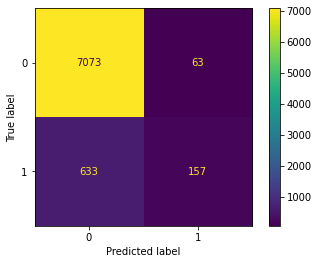

Test accuracy =  0.9121877365632097
Test precision =  0.7136363636363636
Test recall =  0.19873417721518988
Test specificity =  0.9911715246636771
Test AUC =  0.5949528509394335
Test F1 =  0.3108910891089109


In [66]:
# confusion matrix de mi modelo con prediccion de goal automatica (no se que umbral usa) 
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
from sklearn import metrics
  
cm = metrics.confusion_matrix(shots_labels, goal_pred)  

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# display matrix
cm_display.plot()
plt.show()

# accuracy score of the model 
print('Test accuracy = ', metrics.accuracy_score(shots_labels,goal_pred))
print('Test precision = ', metrics.precision_score(shots_labels,goal_pred))
print('Test recall = ', metrics.recall_score(shots_labels,goal_pred))
print('Test specificity = ', metrics.recall_score(shots_labels,goal_pred,pos_label=0))
print('Test AUC = ',metrics.roc_auc_score(shots_labels,goal_pred))
print('Test F1 = ',metrics.f1_score(shots_labels,goal_pred))

### Interpretación  
**Error Tipo 1 (FP): Predicción = 1, Realidad = 0**  
Implica que un disparo que NO terminó en gol fue predicho como gol.  

**Error Tipo 2 (FN): Predicción = 0, Realidad = 1**  
Implica que un disparo que SÍ terminó en gol NO fue predicho como gol.  

**Precisión (Precision score):** es el % de los disparos que fueron predichos como gol y que efectivamente terminaron en gol.  

**Exhaustividad (Recall score):** es el % de los disparos que realmente terminaron en gol y que fueron correctamente predichos como gol.  

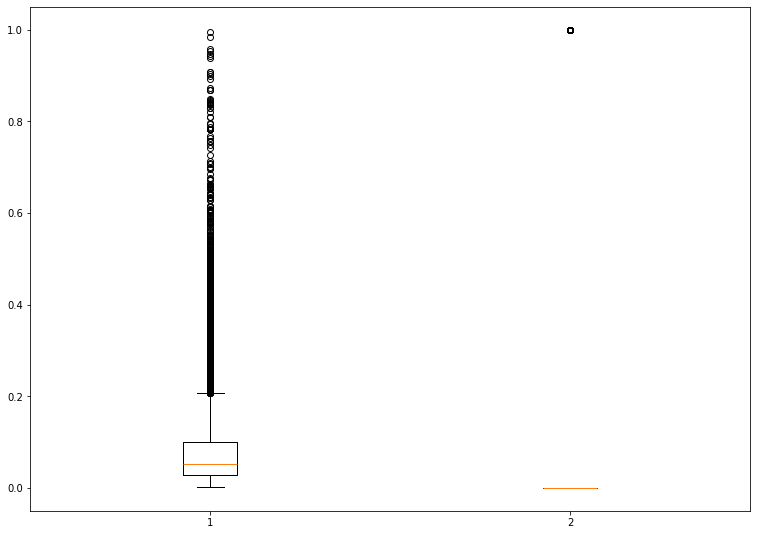

In [67]:
aux = pd.DataFrame({'xg_sb':sb_xg,'goal':shots_labels})
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0,0,1,1])
bp = ax.boxplot(aux)

plt.show()

Text(0, 0.5, 'Statsbomb xG')

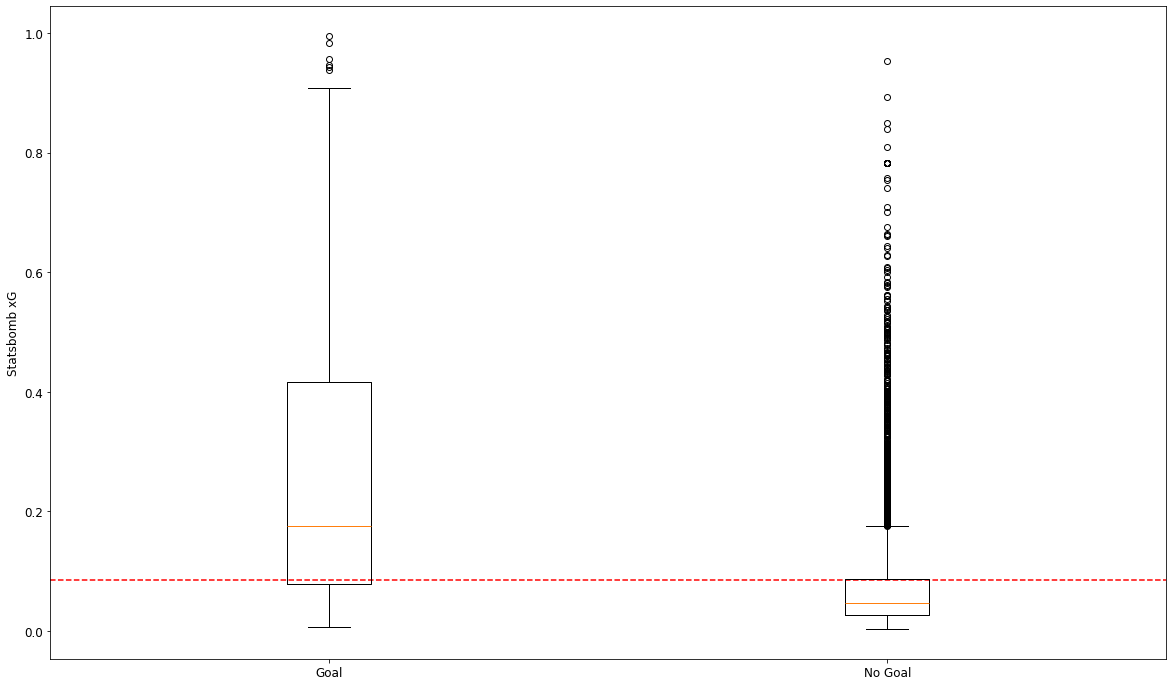

In [68]:
# Comparo si la distribución de los datos de shot_statsbomb_xg 
goal = aux[aux['goal']==1]['xg_sb']
nogoal = aux[aux['goal']==0]['xg_sb']

data = [goal,nogoal]
plt.figure(figsize=(20,12))
plt.axhline(y = 0.085, color = 'r', linestyle = 'dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.boxplot(data,labels=['Goal','No Goal'])
plt.ylabel('Statsbomb xG', fontsize=12)

## Modelo 1: Regresión logística

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
logreg = linear_model.LogisticRegression()
logreg.fit(shots_prepared, shots_labels)

LogisticRegression()

In [70]:
logreg_proba_predictions = logreg.predict_proba(shots_prepared)[:,1].tolist()
logreg_predictions = logreg.predict(shots_prepared)

In [71]:
pd.DataFrame({'sb':sb_xg,'modelo':logreg_proba_predictions})

,sb,modelo
6373,0.400492,0.368828
139,0.372364,0.226248
6940,0.010614,0.011617
6348,0.023575,0.013098
2447,0.037497,0.043673
...,...,...
1862,0.227230,0.203474
7371,0.042522,0.041405
908,0.092451,0.112611
3582,0.085300,0.187775


In [72]:
lin_mse = mean_squared_error(sb_xg, logreg_proba_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.06732936232432406

### Confusion Matrix con umbral por default

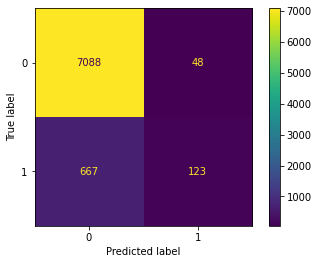

Test accuracy =  0.9097905627050215
Test precision =  0.7192982456140351
Test recall =  0.15569620253164557
Test specificity =  0.9932735426008968
Test AUC =  0.5744848725662711


In [73]:
# confusion matrix de mi modelo con prediccion de goal automatica (no se que umbral usa) 
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
  
cm = metrics.confusion_matrix(shots_labels, logreg_predictions)  

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# display matrix
cm_display.plot()
plt.show()

# accuracy score of the model 
print('Test accuracy = ', metrics.accuracy_score(shots_labels,logreg_predictions))
print('Test precision = ', metrics.precision_score(shots_labels,logreg_predictions))
print('Test recall = ', metrics.recall_score(shots_labels,logreg_predictions))
print('Test specificity = ', metrics.recall_score(shots_labels,logreg_predictions,pos_label=0))
print('Test AUC = ',metrics.roc_auc_score(shots_labels,logreg_predictions))

In [74]:
prueba = pd.DataFrame({'y_pred':logreg_predictions,'y_test':shots_labels})

In [75]:
len(prueba[(prueba['y_pred']==1)&(prueba['y_test']==1)])

123

In [76]:
len(prueba[(prueba['y_pred']==0)&(prueba['y_test']==0)])

7088

In [77]:
len(prueba[(prueba['y_pred']==0)&(prueba['y_test']==1)])

667

In [78]:
len(prueba[(prueba['y_pred']==1)&(prueba['y_test']==0)])

48

### RMSE vs Stasbomb's Model: home-made GridSearchCV

In [79]:
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Función custom: calcula el RMSE entre predict_proba[:,1] y sb_xg
def rmse_sb_xg(estimator, X, y):
    proba_pred = estimator.predict_proba(X)[:,1].tolist()
    # y_true es sb_xg (que debe tener misma longitud que y)
    # asumimos que y tiene esa info
    mse = mean_squared_error(sb_xg, proba_pred)
    return np.sqrt(mse)

In [80]:
rmse_sb_xg(logreg,shots_prepared,sb_xg)

0.06732936232432406

In [81]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error,precision_score,roc_auc_score,f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid):
    try:
        acc_scores = []
        recall_scores = []
        precision_scores = []
        rmse_scores = []
        auc_scores = []
        f1_scores = []
        corr_sb = []

        # Cross-validation loop
        for train_idx, val_idx in kf.split(shots_prepared):
            X_train, X_val = shots_prepared.iloc[train_idx], shots_prepared.iloc[val_idx]
            y_train, y_val = shots_labels.iloc[train_idx], shots_labels.iloc[val_idx]
            sb_xg_val = sb_xg.iloc[val_idx]  # parte de sb_xg correspondiente al fold de validación

            model = LogisticRegression(**params, max_iter=1000)
            model.fit(X_train, y_train)

            #y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:,1]
            y_pred = (y_proba >= 0.42).astype(int)
    
            acc_scores.append(accuracy_score(y_val, y_pred))
            recall_scores.append(recall_score(y_val, y_pred))
            precision_scores.append(precision_score(y_val, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(sb_xg_val, y_proba)))
            auc_scores.append(roc_auc_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            corr_sb.append(np.corrcoef(y_proba,sb_xg_val))

        # Guardar promedio de las métricas
        results.append({
            'params': params,
            'accuracy': np.mean(acc_scores),
            'recall': np.mean(recall_scores),
            'precision':np.mean(precision_scores),
            'rmse': np.mean(rmse_scores),
            'auc': np.mean(auc_scores),
            'f1': np.mean(f1_scores),
            'corr_sb':np.mean(corr_sb)
        })

    except Exception as e:
        print(f"Error con params {params}: {e}")

# Convertir a DataFrame y mostrar ordenado por rmse
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='rmse'))

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
23,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066772,0.586272,0.285363,0.931772
19,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931763
21,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931768
15,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.909539,0.184180,0.664120,0.066784,0.586975,0.287503,0.931685
17,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.909413,0.182914,0.661844,0.066800,0.586342,0.285682,0.931699
13,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.908782,0.177910,0.654031,0.067098,0.583770,0.278906,0.930938
11,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.909160,0.179176,0.662755,0.067340,0.584544,0.281342,0.930238
10,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.910674,0.187975,0.690765,0.067987,0.589293,0.294293,0.928916
9,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}",0.906763,0.161613,0.629706,0.071976,0.575410,0.256392,0.919606
8,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.908403,0.180692,0.650477,0.074470,0.584809,0.282104,0.913370


In [82]:
# Mejor modelo
results_df.iloc[19]

params       {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
accuracy                                         0.909287
recall                                           0.182914
precision                                        0.658905
rmse                                             0.066773
auc                                              0.586272
f1                                               0.285363
corr_sb                                          0.931763
Name: 19, dtype: object

### Comparo el mejor modelo contra Statsbomb

In [83]:
# Convertir a DataFrame
results_df = pd.DataFrame(results)

# Encontrar la fila con el RMSE más bajo
best_row = results_df.iloc[19]
best_params = best_row['params']

print("Mejor combinación de hiperparámetros:", best_params)
print(best_row)
print("RMSE más bajo:", best_row['rmse'])

# Volver a entrenar el modelo con esos hiperparámetros
best_model = LogisticRegression(**best_params, max_iter=1000)
best_model.fit(shots_prepared, shots_labels)

# Calcular predict_proba en todo el dataset
best_proba = best_model.predict_proba(shots_prepared)[:,1]

Mejor combinación de hiperparámetros: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
params       {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
accuracy                                         0.909287
recall                                           0.182914
precision                                        0.658905
rmse                                             0.066773
auc                                              0.586272
f1                                               0.285363
corr_sb                                          0.931763
Name: 19, dtype: object
RMSE más bajo: 0.06677340101873379


In [84]:
print(np.sqrt(mean_squared_error(sb_xg, best_proba)))

0.06602828651113023


In [85]:
# Top 5
results_df.sort_values('rmse').head()

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
23,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066772,0.586272,0.285363,0.931772
19,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931763
21,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931768
15,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.909539,0.184180,0.664120,0.066784,0.586975,0.287503,0.931685
17,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.909413,0.182914,0.661844,0.066800,0.586342,0.285682,0.931699


In [86]:
# Grafico la correlación entre las predicciones del modelo de Statsbomb y el mio
def corr_chart(y,x,colores):    
    from matplotlib.lines import Line2D  # Importar Line2D
    colors = {1: 'limegreen', 0: 'red'}


    plt.figure(figsize=(16,10))
    plt.scatter(y,x,c=colores.map(colors))
    plt.ylabel('Mi modelo', fontsize=14)
    plt.xlabel('Modelo xG de Statsbomb', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend('goal', 'no goal')

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='limegreen', markersize=10, label='Goal'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='No Goal')]

    # Añadir la leyenda al gráfico
    plt.legend(handles=legend_elements, loc='best')


    r = np.corrcoef(x,y)
    r[0, 1]
    print("El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de ",r[0, 1])

In [87]:
aux = pd.DataFrame({'goal':shots_labels,'sb_xg':sb_xg,'modelo':best_proba})
goles = aux[aux['goal']==1]
nogoles = aux[aux['goal']==0]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.868394514993692


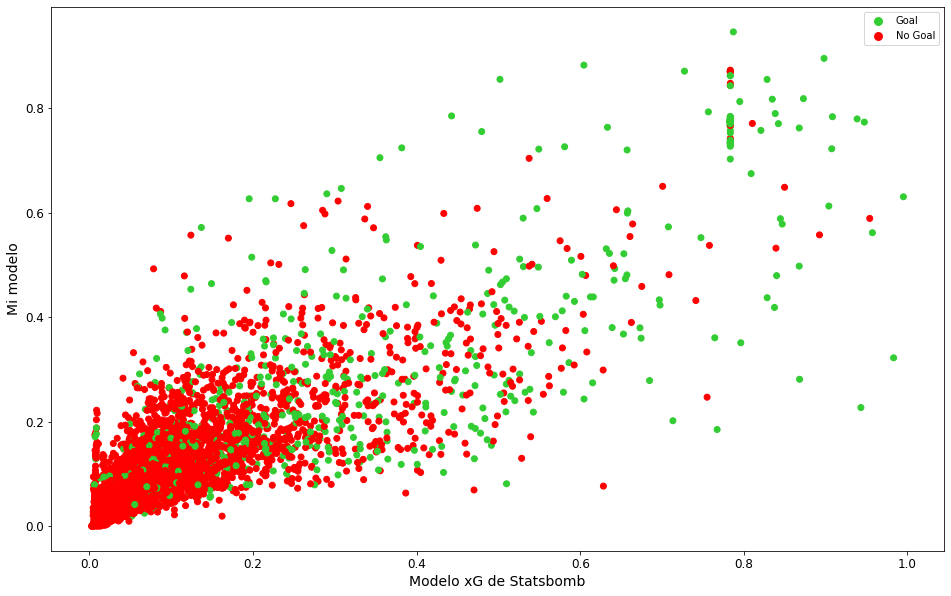

In [88]:
corr_chart(sb_xg,best_proba,shots_labels)

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.8603504756799079


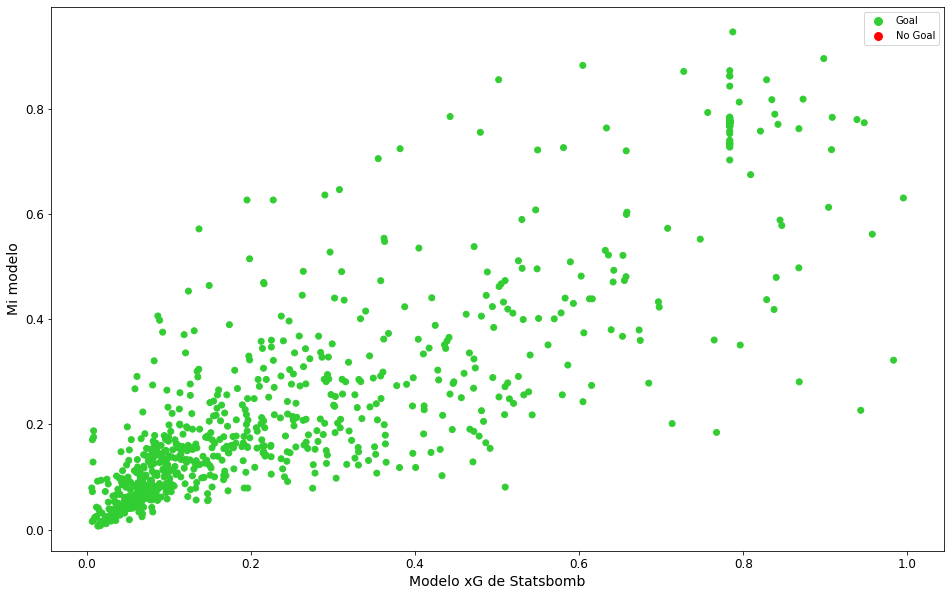

In [89]:
corr_chart(goles['sb_xg'],goles['modelo'],goles['goal'])

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.8186051807162305


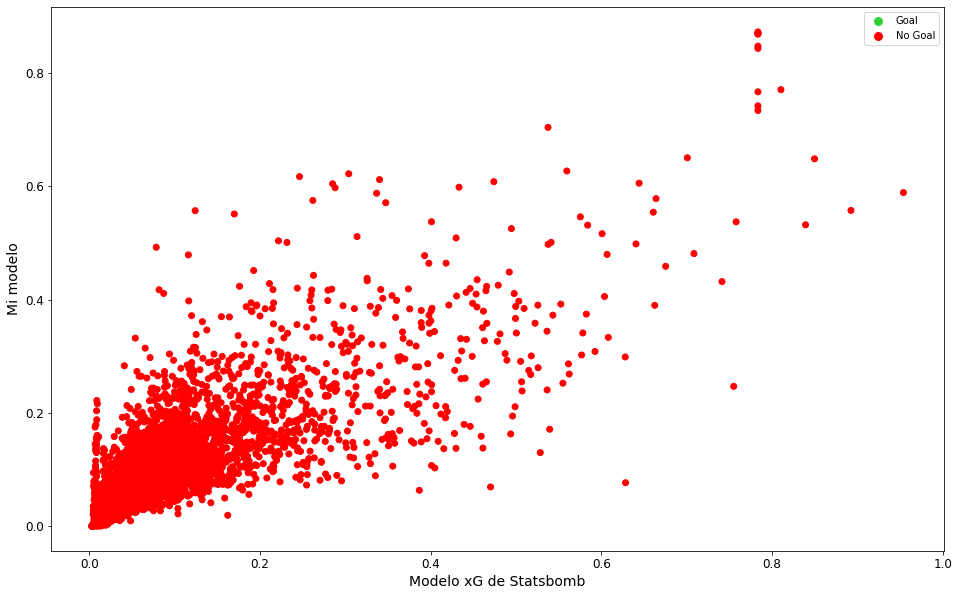

In [90]:
corr_chart(nogoles['sb_xg'],nogoles['modelo'],nogoles['goal'])

## Modelo 2: Random forest

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error
import numpy as np
import pandas as pd

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

results_rf = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid_rf):
    try:
        acc_scores = []
        recall_scores = []
        precision_scores = []
        rmse_scores = []
        auc_scores = []
        f1_scores = []
        corr_sb = []

        for train_idx, val_idx in kf.split(shots_prepared):
            X_train, X_val = shots_prepared.iloc[train_idx], shots_prepared.iloc[val_idx]
            y_train, y_val = shots_labels.iloc[train_idx], shots_labels.iloc[val_idx]
            sb_xg_val = sb_xg.iloc[val_idx]

            model = RandomForestClassifier(**params, random_state=42)
            model.fit(X_train, y_train)

            #y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:,1]
            y_pred = (y_proba >= 0.4).astype(int)

            acc_scores.append(accuracy_score(y_val, y_pred))
            recall_scores.append(recall_score(y_val, y_pred))
            precision_scores.append(precision_score(y_val, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(sb_xg_val, y_proba)))
            auc_scores.append(roc_auc_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            corr_sb.append(np.corrcoef(y_proba,sb_xg_val))

        results_rf.append({
            'params': params,
            'accuracy': np.mean(acc_scores),
            'recall': np.mean(recall_scores),
            'precision':np.mean(precision_scores),
            'rmse': np.mean(rmse_scores),
            'auc': np.mean(auc_scores),
            'f1': np.mean(f1_scores),
            'corr_sb':np.mean(corr_sb)
        })

    except Exception as e:
        print(f"Error con params {params}: {e}")

results_rf_df = pd.DataFrame(results_rf)
display(results_rf_df.sort_values(by='rmse'))

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
7,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.909917,0.174577,0.700006,0.077535,0.582945,0.278230,0.907802
6,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.909160,0.173405,0.677666,0.078187,0.582010,0.274644,0.906411
5,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.909791,0.183257,0.677879,0.078330,0.586725,0.287031,0.906755
4,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.908781,0.178304,0.665622,0.079120,0.583968,0.279538,0.904952
11,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",0.904996,0.216061,0.561094,0.093593,0.598640,0.310962,0.880547
10,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",0.904239,0.222480,0.547676,0.095462,0.601081,0.316078,0.877279
9,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.903861,0.208548,0.545948,0.095546,0.594673,0.300944,0.876237
8,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.903987,0.223779,0.543508,0.096986,0.601519,0.316290,0.873870
3,"{'max_depth': None, 'max_features': 'log2', 'n...",0.902473,0.219897,0.524229,0.097114,0.598947,0.308614,0.874245
2,"{'max_depth': None, 'max_features': 'log2', 'n...",0.902220,0.223691,0.523086,0.099159,0.600492,0.312317,0.870141


In [92]:
# Encontrar la fila con el RMSE más bajo
best_row_rf = results_rf_df.iloc[7]
best_params_rf = best_row_rf['params']

print("Mejor combinación de hiperparámetros:", best_params_rf)
print(best_row_rf)
print("RMSE más bajo:", best_row_rf['rmse'])

Mejor combinación de hiperparámetros: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
params       {'max_depth': 10, 'max_features': 'log2', 'n_e...
accuracy                                              0.909917
recall                                                0.174577
precision                                             0.700006
rmse                                                  0.077535
auc                                                   0.582945
f1                                                     0.27823
corr_sb                                               0.907802
Name: 7, dtype: object
RMSE más bajo: 0.0775354316896413


In [93]:
from sklearn.ensemble import RandomForestClassifier

best_model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_model_rf.fit(shots_prepared, shots_labels)

# Calcular predict_proba en todo el dataset
best_proba_rf = best_model_rf.predict_proba(shots_prepared)[:,1]

In [94]:
aux = pd.DataFrame({'goal':shots_labels,'sb_xg':sb_xg,'modelo':best_proba_rf})
goles = aux[aux['goal']==1]
nogoles = aux[aux['goal']==0]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.8019761529613839


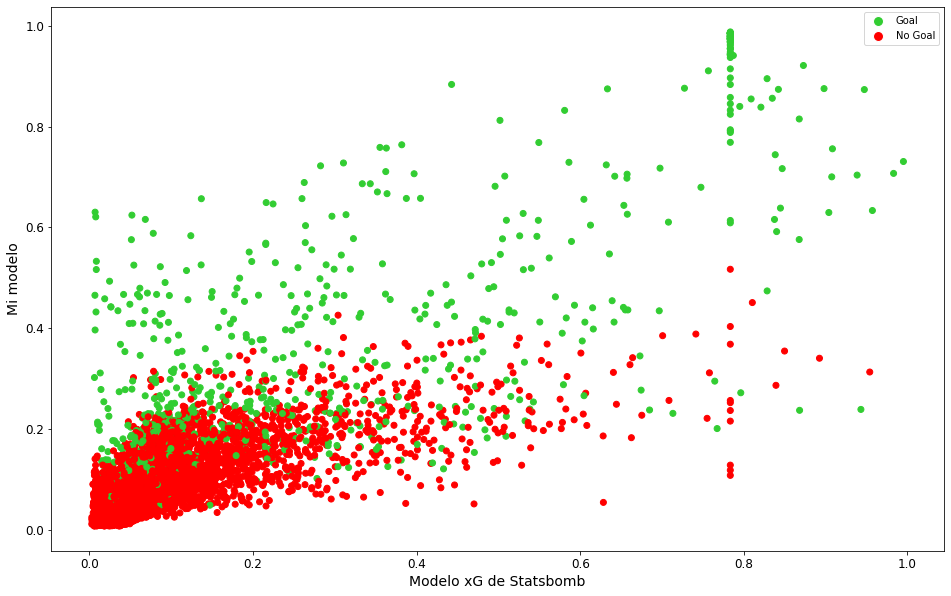

In [95]:
corr_chart(sb_xg,best_proba_rf,shots_labels)

In [96]:
aux = pd.DataFrame({'goal':shots_labels,'sb_xg':sb_xg,'modelo':best_proba_rf})
goles = aux[aux['goal']==1]
nogoles = aux[aux['goal']==0]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.7681345484821345


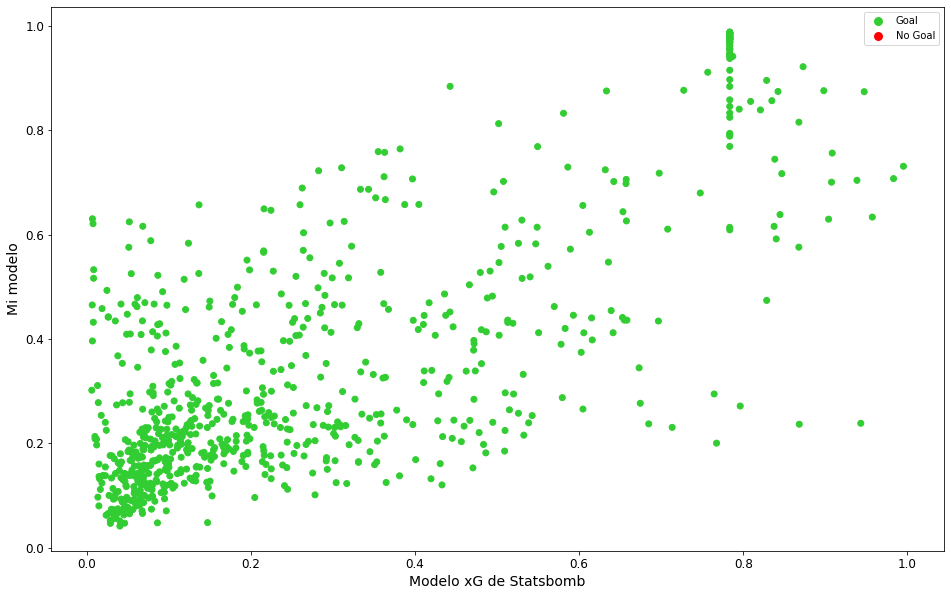

In [97]:
corr_chart(goles['sb_xg'],goles['modelo'],goles['goal'])

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.7493839977826036


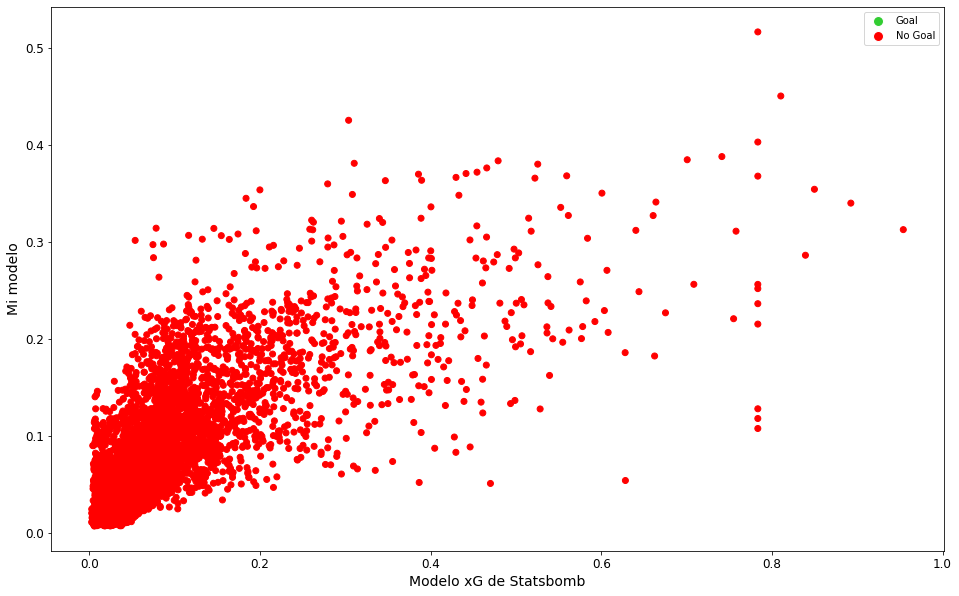

In [98]:
corr_chart(nogoles['sb_xg'],nogoles['modelo'],nogoles['goal'])

## Modelo 3: Catboost

In [99]:
from catboost import CatBoostClassifier

param_grid_cb = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1]
}

results_cb = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid_cb):
    try:
        acc_scores = []
        recall_scores = []
        precision_scores = []
        rmse_scores = []
        auc_scores = []
        f1_scores = []
        corr_sb = []

        for train_idx, val_idx in kf.split(shots_prepared):
            X_train, X_val = shots_prepared.iloc[train_idx], shots_prepared.iloc[val_idx]
            y_train, y_val = shots_labels.iloc[train_idx], shots_labels.iloc[val_idx]
            sb_xg_val = sb_xg.iloc[val_idx]

            model = CatBoostClassifier(**params, verbose=0, random_state=42)
            model.fit(X_train, y_train)

            #y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:,1]
            y_pred = (y_proba >= 0.4).astype(int)

            acc_scores.append(accuracy_score(y_val, y_pred))
            recall_scores.append(recall_score(y_val, y_pred))
            precision_scores.append(precision_score(y_val, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(sb_xg_val, y_proba)))
            auc_scores.append(roc_auc_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            corr_sb.append(np.corrcoef(y_proba,sb_xg_val))

        results_cb.append({
            'params': params,
            'accuracy': np.mean(acc_scores),
            'recall': np.mean(recall_scores),
            'precision':np.mean(precision_scores),
            'rmse': np.mean(rmse_scores),
            'auc': np.mean(auc_scores),
            'f1': np.mean(f1_scores),
            'corr_sb':np.mean(corr_sb)
        })

    except Exception as e:
        print(f"Error con params {params}: {e}")

results_cb_df = pd.DataFrame(results_cb)
display(results_cb_df.sort_values(by='rmse'))

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
1,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.909286,0.198496,0.648402,0.077110,0.593223,0.302748,0.911471
6,"{'depth': 6, 'iterations': 200, 'learning_rate...",0.910422,0.148738,0.751144,0.077867,0.571706,0.247168,0.916251
2,"{'depth': 4, 'iterations': 200, 'learning_rate...",0.909538,0.133579,0.759613,0.080834,0.564477,0.226425,0.912534
5,"{'depth': 6, 'iterations': 100, 'learning_rate...",0.905753,0.198334,0.580695,0.081536,0.591181,0.293905,0.904045
3,"{'depth': 4, 'iterations': 200, 'learning_rate...",0.906385,0.201096,0.588365,0.084935,0.592770,0.298923,0.899139
7,"{'depth': 6, 'iterations': 200, 'learning_rate...",0.904618,0.216261,0.556845,0.092675,0.598530,0.311018,0.885140
4,"{'depth': 6, 'iterations': 100, 'learning_rate...",0.909160,0.133660,0.744603,0.117494,0.564307,0.225890,0.904411
0,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.907898,0.107282,0.765822,0.122504,0.551890,0.187792,0.897925


In [100]:
best_row_cb = results_cb_df.iloc[1]
best_params_cb = best_row_cb['params']

print("Mejor combinación de hiperparámetros:", best_params_cb)
print(best_row_cb)
print("RMSE más bajo:", best_row_cb['rmse'])

Mejor combinación de hiperparámetros: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
params       {'depth': 4, 'iterations': 100, 'learning_rate...
accuracy                                              0.909286
recall                                                0.198496
precision                                             0.648402
rmse                                                   0.07711
auc                                                   0.593223
f1                                                    0.302748
corr_sb                                               0.911471
Name: 1, dtype: object
RMSE más bajo: 0.07710956623649796


In [101]:
best_model_cb = CatBoostClassifier(**best_params_cb, verbose=0, random_state=42)
best_model_cb.fit(shots_prepared, shots_labels)

# Calcular predict_proba en todo el dataset
best_proba_cb = best_model_cb.predict_proba(shots_prepared)[:,1]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.8265789145284367


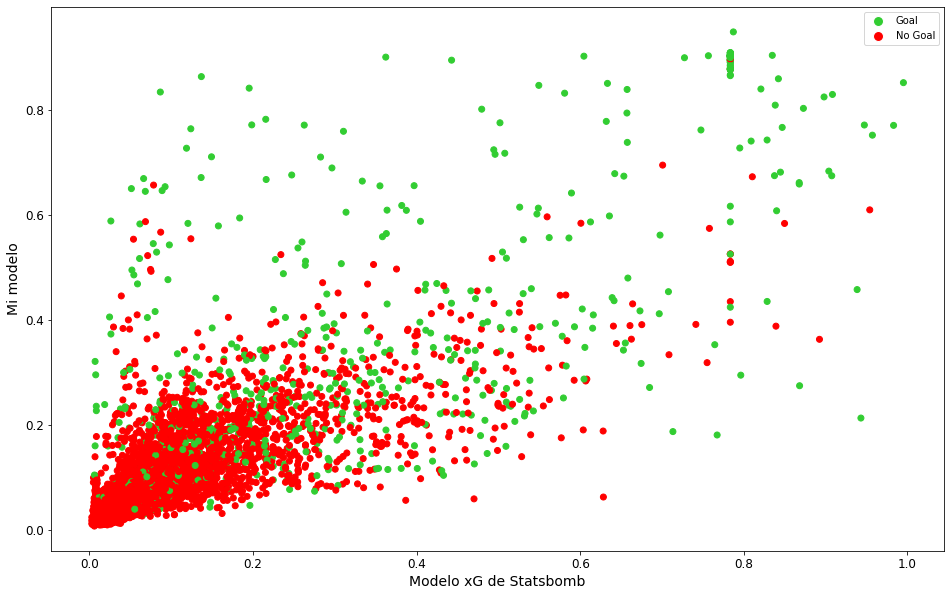

In [102]:
corr_chart(sb_xg,best_proba_cb,shots_labels)

In [103]:
aux = pd.DataFrame({'goal':shots_labels,'sb_xg':sb_xg,'modelo':best_proba_cb})
goles = aux[aux['goal']==1]
nogoles = aux[aux['goal']==0]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.7843738675875717


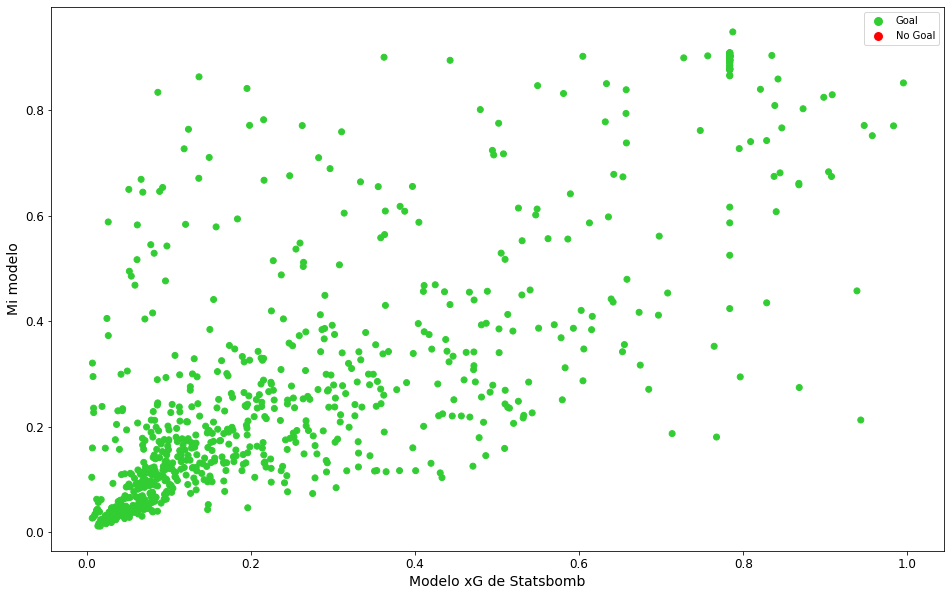

In [104]:
corr_chart(goles['sb_xg'],goles['modelo'],goles['goal'])

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.7774469692678257


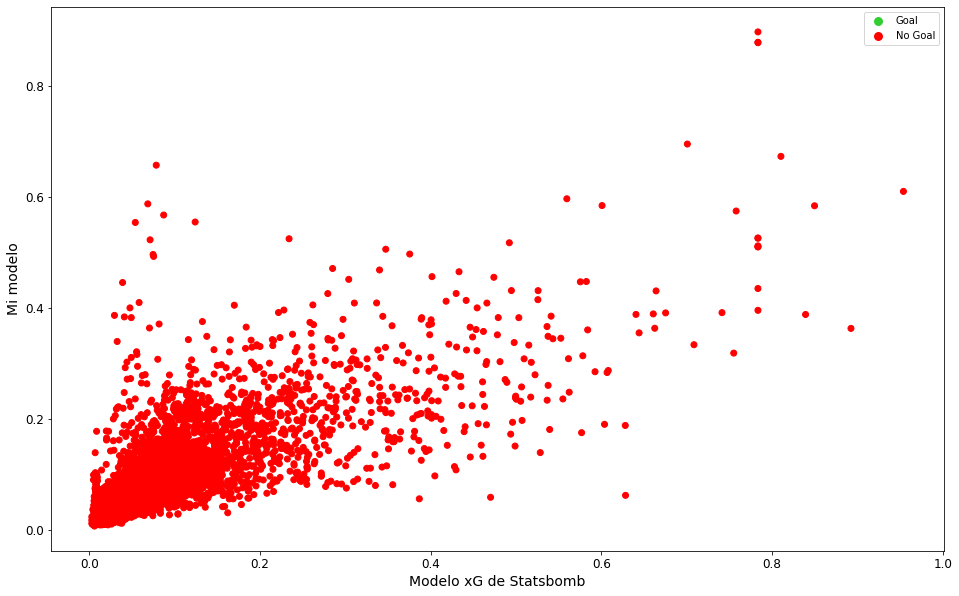

In [105]:
corr_chart(nogoles['sb_xg'],nogoles['modelo'],nogoles['goal'])

## Modelo 4: Linear Discriminant Analysis (LDA)

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid_lda = [
    {'solver': ['svd']},  # svd no admite shrinkage
    {'solver': ['lsqr'], 'shrinkage': ['auto', None, 0.1, 0.5, 0.9]},  # lsqr sí admite todo
    {'solver': ['eigen'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}  # evitamos None con eigen
]

results_lda = []

for params in ParameterGrid(param_grid_lda):
    try:
        acc_scores = []
        recall_scores = []
        precision_scores = []
        rmse_scores = []
        auc_scores = []
        f1_scores = []
        corr_sb = []

        for train_idx, val_idx in kf.split(shots_prepared):
            X_train, X_val = shots_prepared.iloc[train_idx], shots_prepared.iloc[val_idx]
            y_train, y_val = shots_labels.iloc[train_idx], shots_labels.iloc[val_idx]
            sb_xg_val = sb_xg.iloc[val_idx]

            model = LinearDiscriminantAnalysis(**params)
            model.fit(X_train, y_train)

            y_proba = model.predict_proba(X_val)[:, 1]
            #y_pred = (y_proba >= 0.4).astype(int)
            y_pred = model.predict(X_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            recall_scores.append(recall_score(y_val, y_pred))
            precision_scores.append(precision_score(y_val, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(sb_xg_val, y_proba)))
            auc_scores.append(roc_auc_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            corr_sb.append(np.corrcoef(y_proba, sb_xg_val)[0,1])

        results_lda.append({
            'params': params,
            'accuracy': np.mean(acc_scores),
            'recall': np.mean(recall_scores),
            'precision': np.mean(precision_scores),
            'rmse': np.mean(rmse_scores),
            'auc': np.mean(auc_scores),
            'f1': np.mean(f1_scores),
            'corr_sb': np.mean(corr_sb)
        })

    except Exception as e:
        print(f"Error con params {params}: {e}")

results_lda_df = pd.DataFrame(results_lda)
display(results_lda_df.sort_values(by='rmse'))

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
1,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.904240,0.229705,0.548784,0.115468,0.604270,0.322377,0.751351
6,"{'shrinkage': 'auto', 'solver': 'eigen'}",0.904240,0.229705,0.548784,0.115468,0.604270,0.322377,0.751351
0,{'solver': 'svd'},0.903861,0.234932,0.545671,0.116607,0.606394,0.326970,0.748230
2,"{'shrinkage': None, 'solver': 'lsqr'}",0.903861,0.234932,0.545671,0.116629,0.606394,0.326970,0.748203
3,"{'shrinkage': 0.1, 'solver': 'lsqr'}",0.891875,0.118842,0.369431,0.121072,0.548137,0.179250,0.614869
7,"{'shrinkage': 0.1, 'solver': 'eigen'}",0.891875,0.118842,0.369431,0.121072,0.548137,0.179250,0.614869
4,"{'shrinkage': 0.5, 'solver': 'lsqr'}",0.871941,0.220038,0.306957,0.169129,0.582062,0.255710,0.591464
8,"{'shrinkage': 0.5, 'solver': 'eigen'}",0.871941,0.220038,0.306957,0.169129,0.582062,0.255710,0.591464
5,"{'shrinkage': 0.9, 'solver': 'lsqr'}",0.798511,0.457670,0.236656,0.317378,0.646928,0.311822,0.539541
9,"{'shrinkage': 0.9, 'solver': 'eigen'}",0.798511,0.457670,0.236656,0.317378,0.646928,0.311822,0.539541


Justifico este pobre rendimiento con los supuestos

In [107]:
best_row_lda = results_lda_df.iloc[1]
best_params_lda = best_row_lda['params']

print("Mejor combinación de hiperparámetros:", best_params_lda)
print(best_row_lda)
print("RMSE más bajo:", best_row_lda['rmse'])

Mejor combinación de hiperparámetros: {'shrinkage': 'auto', 'solver': 'lsqr'}
params       {'shrinkage': 'auto', 'solver': 'lsqr'}
accuracy                                     0.90424
recall                                      0.229705
precision                                   0.548784
rmse                                        0.115468
auc                                          0.60427
f1                                          0.322377
corr_sb                                     0.751351
Name: 1, dtype: object
RMSE más bajo: 0.11546817250387253


## Modelo 5: XGBoost

In [108]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

results_xgb = []

for params in ParameterGrid(param_grid_xgb):
    try:
        acc_scores = []
        recall_scores = []
        precision_scores = []
        rmse_scores = []
        auc_scores = []
        f1_scores = []
        corr_sb = []

        for train_idx, val_idx in kf.split(shots_prepared):
            X_train, X_val = shots_prepared.iloc[train_idx], shots_prepared.iloc[val_idx]
            y_train, y_val = shots_labels.iloc[train_idx], shots_labels.iloc[val_idx]
            sb_xg_val = sb_xg.iloc[val_idx]

            model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train, y_train)

            y_proba = model.predict_proba(X_val)[:, 1]
            y_pred = (y_proba >= 0.4).astype(int)

            acc_scores.append(accuracy_score(y_val, y_pred))
            recall_scores.append(recall_score(y_val, y_pred))
            precision_scores.append(precision_score(y_val, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(sb_xg_val, y_proba)))
            auc_scores.append(roc_auc_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            corr_sb.append(np.corrcoef(y_proba, sb_xg_val)[0,1])

        results_xgb.append({
            'params': params,
            'accuracy': np.mean(acc_scores),
            'recall': np.mean(recall_scores),
            'precision': np.mean(precision_scores),
            'rmse': np.mean(rmse_scores),
            'auc': np.mean(auc_scores),
            'f1': np.mean(f1_scores),
            'corr_sb': np.mean(corr_sb)
        })

    except Exception as e:
        print(f"Error con params {params}: {e}")

results_xgb_df = pd.DataFrame(results_xgb)
display(results_xgb_df.sort_values(by='rmse'))

,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
4,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.906637,0.194711,0.600376,0.078363,0.590069,0.292901,0.816591
3,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.907646,0.146490,0.668231,0.079188,0.569182,0.239826,0.806369
1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.908277,0.120953,0.749070,0.080408,0.558164,0.207080,0.811274
5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.904744,0.199797,0.563562,0.085129,0.591280,0.294364,0.796096
6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.906637,0.203649,0.596623,0.087125,0.594049,0.300932,0.787975
2,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.908403,0.104846,0.817467,0.089930,0.551092,0.185533,0.800371
0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.907520,0.078408,0.923180,0.095396,0.538854,0.144279,0.786860
7,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.904997,0.222554,0.561701,0.098687,0.601540,0.317600,0.749378


In [109]:
best_row_xgb = results_xgb_df.iloc[3]
best_params_xgb = best_row_xgb['params']

print("Mejor combinación de hiperparámetros:", best_params_xgb)
print(best_row_xgb)
print("RMSE más bajo:", best_row_xgb['rmse'])

Mejor combinación de hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
params       {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
accuracy                                              0.907646
recall                                                 0.14649
precision                                             0.668231
rmse                                                  0.079188
auc                                                   0.569182
f1                                                    0.239826
corr_sb                                               0.806369
Name: 3, dtype: object
RMSE más bajo: 0.07918789109513244


In [110]:
best_model_xgb = CatBoostClassifier(**best_params_xgb, verbose=0, random_state=42)
best_model_xgb.fit(shots_prepared, shots_labels)

# Calcular predict_proba en todo el dataset
best_proba_xgb = best_model_xgb.predict_proba(shots_prepared)[:,1]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.833877592962499


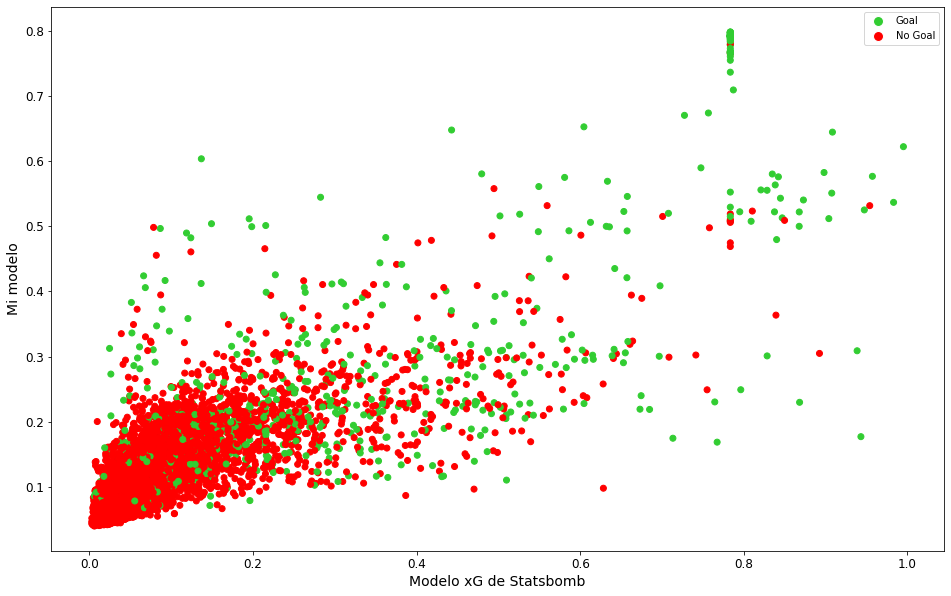

In [111]:
corr_chart(sb_xg,best_proba_xgb,shots_labels)

In [112]:
aux = pd.DataFrame({'goal':shots_labels,'sb_xg':sb_xg,'modelo':best_proba_xgb})
goles = aux[aux['goal']==1]
nogoles = aux[aux['goal']==0]

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.8136043564558552


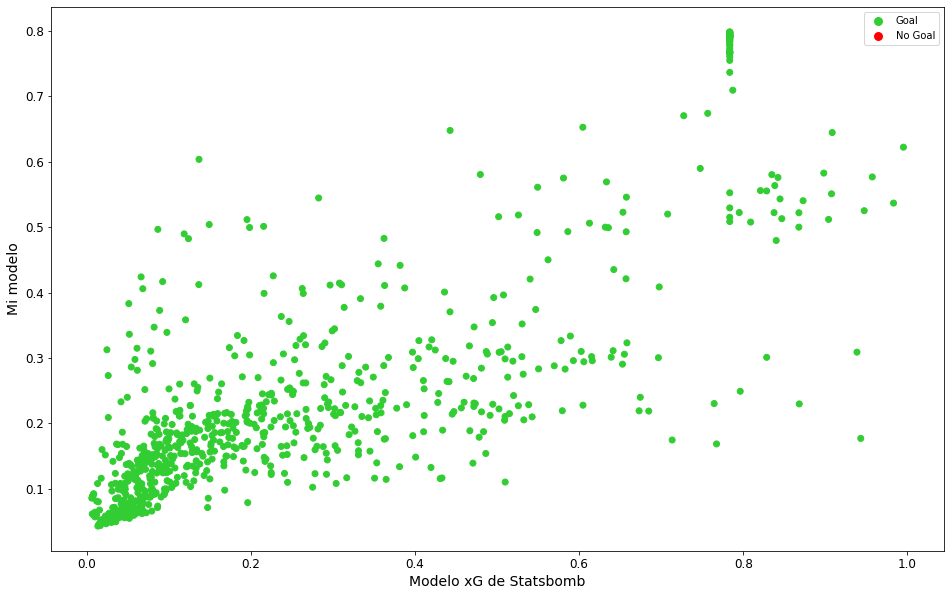

In [113]:
corr_chart(goles['sb_xg'],goles['modelo'],goles['goal'])

El coeficiente de correlación entre mi modelo y el de xG de Statsbomb es de  0.7726389569971318


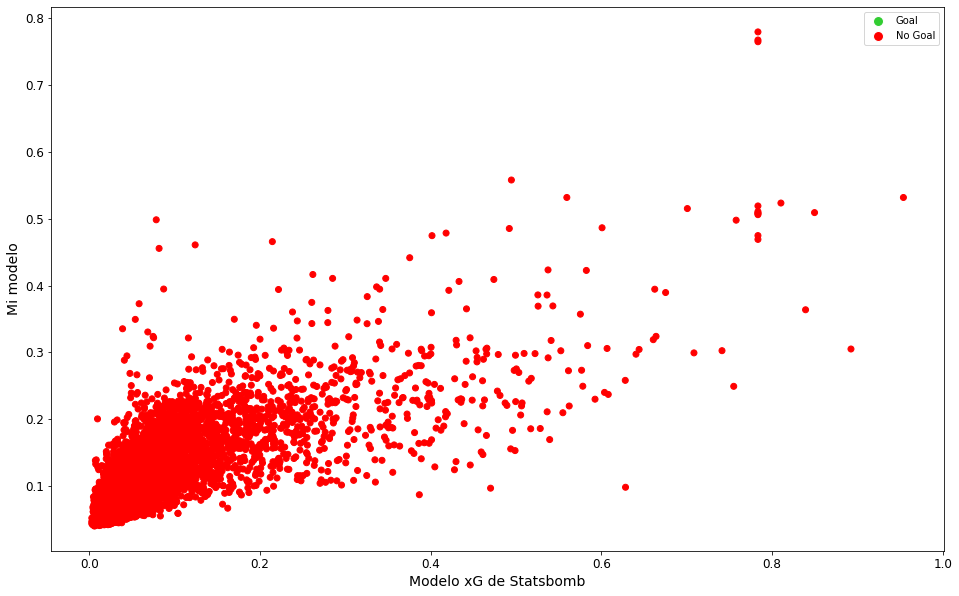

In [114]:
corr_chart(nogoles['sb_xg'],nogoles['modelo'],nogoles['goal'])

## Comparación entre modelos

In [115]:
# Agregás el nombre del modelo como columna
best_row["modelo"] = "Logistic Regression"
best_row_rf["modelo"] = "Random Forest"
best_row_cb["modelo"] = "CatBoost"
best_row_xgb["modelo"] = "XGBoost"
best_row_lda["modelo"] = "LDA"

mejores_modelos_df = pd.DataFrame([
    best_row,
    best_row_rf,
    best_row_cb,
    best_row_xgb,
    best_row_lda
])

cols = ["modelo"] + [col for col in mejores_modelos_df.columns if col != "modelo"]
mejores_modelos_df = mejores_modelos_df[cols]

# Resultado
mejores_modelos_df

,modelo,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
19,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931763
7,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.909917,0.174577,0.700006,0.077535,0.582945,0.278230,0.907802
1,CatBoost,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.909286,0.198496,0.648402,0.077110,0.593223,0.302748,0.911471
3,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.907646,0.146490,0.668231,0.079188,0.569182,0.239826,0.806369
1,LDA,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.904240,0.229705,0.548784,0.115468,0.604270,0.322377,0.751351


### Benchmark

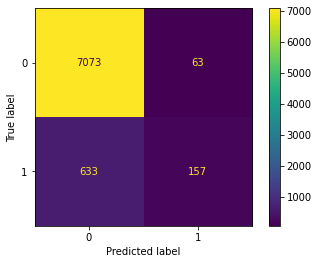

Test accuracy =  0.9121877365632097
Test precision =  0.7136363636363636
Test recall =  0.19873417721518988
Test AUC =  0.5949528509394335
Test F1 =  0.3108910891089109


In [116]:
cm = metrics.confusion_matrix(shots_labels, goal_pred)  

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# display matrix
cm_display.plot()
plt.show()

# accuracy score of the model 
print('Test accuracy = ', metrics.accuracy_score(shots_labels,goal_pred))
print('Test precision = ', metrics.precision_score(shots_labels,goal_pred))
print('Test recall = ', metrics.recall_score(shots_labels,goal_pred))
print('Test AUC = ',metrics.roc_auc_score(shots_labels,goal_pred))
print('Test F1 = ',metrics.f1_score(shots_labels,goal_pred))

In [117]:
from sklearn import metrics
import pandas as pd

# Calcular métricas
accuracy = metrics.accuracy_score(shots_labels, goal_pred)
precision = metrics.precision_score(shots_labels, goal_pred)
recall = metrics.recall_score(shots_labels, goal_pred)
auc = metrics.roc_auc_score(shots_labels, goal_pred)
f1 = metrics.f1_score(shots_labels, goal_pred)

# Crear diccionario con las métricas
result_dict = {
    'modelo': 'SB',
    'params':'Unknown',# cambiá esto por ejemplo a 'XGBoost'
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'rmse':0,
    'auc': auc,
    'f1': f1,
    'corr_sb':1
}

# Convertir a DataFrame con una sola fila
result_df = pd.DataFrame([result_dict])
result_df

,modelo,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
0,SB,Unknown,0.912188,0.198734,0.713636,0,0.594953,0.310891,1


In [118]:
#mejores_modelos_df = pd.concat([mejores_modelos_df, result_df], ignore_index=True)

In [119]:
mejores_modelos_df

,modelo,params,accuracy,recall,precision,rmse,auc,f1,corr_sb
19,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931763
7,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.909917,0.174577,0.700006,0.077535,0.582945,0.278230,0.907802
1,CatBoost,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.909286,0.198496,0.648402,0.077110,0.593223,0.302748,0.911471
3,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.907646,0.146490,0.668231,0.079188,0.569182,0.239826,0.806369
1,LDA,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.904240,0.229705,0.548784,0.115468,0.604270,0.322377,0.751351


In [120]:
# Suponiendo que tu DataFrame se llama `mejores_modelos_df`
# y tiene estas columnas: ['modelo', 'accuracy', 'precision', 'recall', 'auc', 'f1']

# Crear columnas de ranking (mayor valor = mejor ranking → rank 1)
for col in ['accuracy','recall','precision','rmse', 'auc', 'f1','corr_sb']:
    if col == 'rmse':
        # Menor es mejor para RMSE
        mejores_modelos_df[f'ranking_{col}'] = mejores_modelos_df[col].rank(ascending=True, method='min')
    else:
        # Mayor es mejor para las demás métricas
        mejores_modelos_df[f'ranking_{col}'] = mejores_modelos_df[col].rank(ascending=False, method='min')

In [121]:
mejores_modelos_df['avg_ranking'] = 0.2*(mejores_modelos_df['ranking_rmse']+mejores_modelos_df['ranking_recall']+mejores_modelos_df['ranking_precision']+mejores_modelos_df['ranking_corr_sb'])+(0.2/3)*(mejores_modelos_df['ranking_accuracy']+mejores_modelos_df['ranking_auc']+mejores_modelos_df['ranking_f1'])


In [122]:
mejores_modelos_df.sort_values('avg_ranking',ascending=1)

,modelo,params,accuracy,recall,precision,rmse,auc,f1,corr_sb,ranking_accuracy,ranking_recall,ranking_precision,ranking_rmse,ranking_auc,ranking_f1,ranking_corr_sb,avg_ranking
19,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.909287,0.182914,0.658905,0.066773,0.586272,0.285363,0.931763,2.0,3.0,3.0,1.0,3.0,3.0,1.0,2.133333
1,CatBoost,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.909286,0.198496,0.648402,0.077110,0.593223,0.302748,0.911471,3.0,2.0,4.0,2.0,2.0,2.0,2.0,2.466667
7,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.909917,0.174577,0.700006,0.077535,0.582945,0.278230,0.907802,1.0,4.0,1.0,3.0,4.0,4.0,3.0,2.800000
1,LDA,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.904240,0.229705,0.548784,0.115468,0.604270,0.322377,0.751351,5.0,1.0,5.0,5.0,1.0,1.0,5.0,3.666667
3,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.907646,0.146490,0.668231,0.079188,0.569182,0.239826,0.806369,4.0,5.0,2.0,4.0,5.0,5.0,4.0,3.933333


El mejor modelo es el de regresión logística

## Predicciones en el test set

In [123]:
# Convertir a DataFrame
results_df = pd.DataFrame(results)

# Encontrar la fila con el RMSE más bajo
best_row = results_df.iloc[19]
best_params = best_row['params']

print("Mejor combinación de hiperparámetros:", best_params)
print(best_row)
print("RMSE más bajo:", best_row['rmse'])

# Volver a entrenar el modelo con esos hiperparámetros
best_model = LogisticRegression(**best_params, max_iter=1000)
best_model.fit(shots_prepared, shots_labels)

# Calcular predict_proba en todo el dataset
best_proba = best_model.predict_proba(shots_prepared)[:,1]

Mejor combinación de hiperparámetros: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
params       {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
accuracy                                         0.909287
recall                                           0.182914
precision                                        0.658905
rmse                                             0.066773
auc                                              0.586272
f1                                               0.285363
corr_sb                                          0.931763
Name: 19, dtype: object
RMSE más bajo: 0.06677340101873379


In [124]:
final_model = LogisticRegression(**best_params, max_iter=1000)

In [125]:
test_set = strat_test_set.copy()

In [126]:
sb_xg_test=test_set["shot_statsbomb_xg"].copy()

In [127]:
test_set = test_set[['location', 'minute', 'play_pattern', 'shot_aerial_won', 'shot_body_part', 
             'shot_first_time', 'shot_one_on_one', 'shot_outcome', 'shot_technique', 'shot_type', 
             'under_pressure', 'shot_open_goal', 'shot_redirect', 'shot_deflected', 'shot_follows_dribble']]
test_set['goal'] = test_set['shot_outcome'].apply(lambda outcome: 1 if outcome=='Goal' else 0)
test_set.drop(columns=['shot_outcome'], inplace=True)

In [128]:
len(test_set)

1982

In [129]:
y_test = test_set["goal"].copy()
X_test_prepared = pipeline.transform(test_set)
X_test_prepared = X_test_prepared.drop("goal", axis=1)

In [130]:
X_test_prepared.sort_values('x',ascending=0)

,minute,shot_aerial_won,shot_first_time,shot_one_on_one,under_pressure,shot_open_goal,shot_redirect,shot_deflected,shot_follows_dribble,x,...,shot_type_Penalty,distancia_arco,angulo,franja_central,dentro_del_area,distancia_arco*franja_central,distancia/angulo,first_time_dentro_area,central_one_on_one,angulo_one_on_one
1659,1,0,0,1,0,0,0,0,0,120.2,...,False,39.000513,0.055637,0,0,0.000000,36.944999,0,0,0.055637
426,31,0,1,0,0,0,0,0,0,119.5,...,False,9.413288,2.785866,1,1,9.413288,2.486429,1,0,0.000000
100,73,0,1,0,1,1,0,0,0,119.3,...,False,0.921954,157.783420,1,1,0.921954,0.005806,1,0,0.000000
307,47,0,0,0,0,0,0,0,0,119.2,...,False,7.741447,7.172534,1,1,7.741447,0.947252,0,0,0.000000
312,43,0,1,0,0,1,0,0,0,119.1,...,False,6.562012,12.521282,1,1,6.562012,0.485310,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,26,0,0,0,0,0,0,0,0,78.5,...,False,51.443270,6.581314,0,0,0.000000,6.785535,0,0,0.000000
1490,7,0,0,0,0,0,0,0,0,75.5,...,False,45.031767,9.185254,1,0,45.031767,4.421271,0,0,0.000000
940,74,0,0,0,0,0,0,0,0,57.3,...,False,64.377403,6.339616,1,0,64.377403,8.771223,0,0,0.000000
558,95,0,0,0,1,0,0,0,0,55.8,...,False,69.190173,5.622117,0,0,0.000000,10.448347,0,0,0.000000


In [131]:
final_model.fit(X_test_prepared, y_test)
final_predictions = final_model.predict_proba(X_test_prepared)[:,1]

In [132]:
final_mse = mean_squared_error(sb_xg_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

0.08266787614451349

In [133]:
# El RMSE final en el test set es levemente superior al RMSE que se observó en el train set